In [13]:
import os
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
import numpy as np


from ipywidgets import Layout, interact, IntSlider, FloatSlider
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default

import DL_Sequence

num_classes = 5
res = 256
exPT_cnt = 10
devPT_cnt = 0
exIntensity=1.0
devIntensity=0.0

mode = "static"
PSF_path="../PSF_subpx_fl32.npy"
PSF = np.load(PSF_path)

# dataset = DL_Sequence.iSCAT_DataGenerator(batch_size=4, epoch_size=1024, res=res, frames=32, thread_count=10,
#                     PSF_path="../PSF_subpx_fl32.npy", exD=5000, devD=4000, exPT_cnt=500, devPT_cnt=499, exIntensity=1.0, devIntensity=0.3, target_frame=15,
#                     num_classes=num_classes, verbose = 2, noise_func = None, mode = mode)

dataset = DL_Sequence.iSCAT_DataGenerator(batch_size=32, epoch_size=128, res=res, frames=64, thread_count=40,
                    PSF_path=PSF_path, exD=5000, devD=4000, exPT_cnt=exPT_cnt, devPT_cnt=devPT_cnt, exIntensity=exIntensity, devIntensity=devIntensity, target_frame=15,
                    num_classes=num_classes, verbose = 2, noise_func = None, mode = mode)

data = dataset.samples
targets = dataset.particles_in_sight_cnt
poss = dataset.particle_positions
pt_cnts = dataset.pt_cnts
dataset.destroy()



Sample width:  256
particlesWorker: Run
Particle generation time: 0.001s
sampleWorker:particlesWorker:  RunRun

Particle generation time: 0.000s
Conv generation time: 0.073s
Target generation time: 0.001s
Whole generation time: 0.100s
Sparse Subpixel Convolution initialized
Preparation of memory took 1378 ms

OMP max threads: 64
OMP setting number of threads to 40
Computation of convolutions took 72 ms
sampleWorker:particlesWorker:  RunRun

Particle generation time: 0.000s
Conv generation time: 0.067s
Target generation time: 0.001s
Whole generation time: 0.092s
Min particle in sight cnt: 4
Max particle in sight cnt: 4
Avg particle in sight cnt: 4.0
Std particle in sight cnt: 0.0
class: 0     |1     |2     |3     |4     |
count: 0     |0     |0     |0     |128   |

OMP max threads: 40
OMP setting number of threads to 40
Computation of convolutions took 66 ms
sampleWorker:particlesWorker:  Die
Die


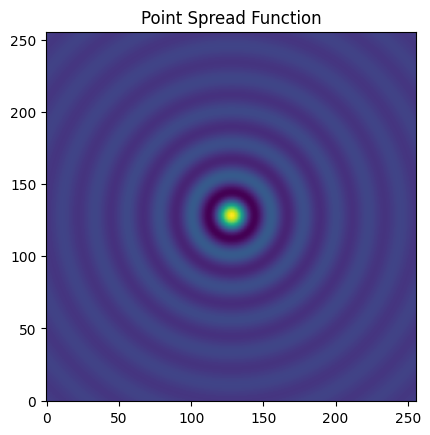

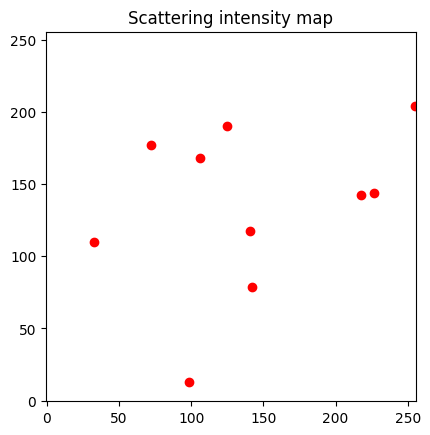

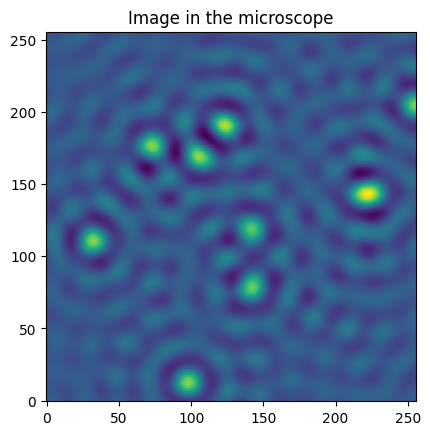

In [14]:
edge = int((PSF.shape[2] - res) / 2)
plt.imshow(PSF[0, 0, edge:-edge, edge:-edge])
plt.axis([-0.5, res-0.5, -0.5, res-0.5])
plt.title("Point Spread Function")
plt.show()

sample_inds = np.insert(np.cumsum(pt_cnts), 0, 0)

sample_cur = 0
step = 0

sample_size_px = 256
FOV_edge = sample_size_px / 2 - res / 2
 
imgs = data[sample_cur]

begin = sample_inds[sample_cur]
end = begin + pt_cnts[sample_cur]

x = poss[step, begin:end, 1]
y = poss[step, begin:end, 0]


# plt.imshow(imgs[step, :, :])
plt.gca().set_aspect('equal')
plt.axis([-0.5, res-0.5, -0.5, res-0.5])
plt.scatter(x,y, c="red")
plt.title("Scattering intensity map")
plt.show()

plt.gca().set_aspect('equal')
plt.axis([-0.5, res-0.5, -0.5, res-0.5])
plt.imshow(data[sample_cur, step])
plt.title("Image in the microscope")
plt.show()

In [4]:
import tensorflow as tf

test_model = False

print(data.shape, targets.shape)

print(np.max(data), np.min(data))
print(np.mean(targets), np.std(targets))

if test_model:
    model_name = "models/model_dense_5000_simple_" + mode
    model = tf.keras.models.load_model(model_name + ".h5")
    predictions = tf.argmax(model.predict(data), axis = 1)
    predictions = np.array(predictions)
    print("Accuracy: ", np.mean(predictions == targets))



(128, 64, 256, 256) (128,)
1.0 0.0
3.9765625 0.15128841196122722


In [5]:
sample_inds = np.insert(np.cumsum(pt_cnts), 0, 0)

sample_size_px = 480
FOV_edge = sample_size_px / 2 - res / 2

def plot_step_fast(step, sample_cur):    
    imgs = data[sample_cur]
    
    begin = sample_inds[sample_cur]
    end = begin + pt_cnts[sample_cur]
    
    poss_step = step % poss.shape[0]
    
    x = poss[poss_step, begin:end, 1]
    y = poss[poss_step, begin:end, 0]
    
    plt.subplot(1, 2, 1)
    plt.axis([-FOV_edge, sample_size_px-FOV_edge, -FOV_edge, sample_size_px-FOV_edge])
    plt.gca().add_patch(Rectangle((0, 0), res, res, edgecolor = 'red', fill=False))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.scatter(x,y)
    
    plt.subplot(1, 2, 2)
    plt.imshow(imgs[step, :, :])
    plt.axis([-0.5, res-0.5, -0.5, res-0.5])
    plt.scatter(x,y, c="red")
    plt.title("data")
    plt.show()
    
    print("gold:", targets[sample_cur])
    if test_model:
        print("pred:", int(predictions[sample_cur]))


    
interact(plot_step_fast, step=IntSlider(min=0, max=data.shape[1] - 1), sample_cur=IntSlider(min=0, max=data.shape[0] - 1));

interactive(children=(IntSlider(value=0, description='step', max=63), IntSlider(value=0, description='sample_c…